# Implementasi Autoencoder dengan JAX, Flax NNX, dan Grain

Notebook ini mendemonstrasikan cara membangun dan melatih model **Autoencoder** (dan **Denoising Autoencoder**) menggunakan ekosistem JAX modern:
*   **JAX**: Library untuk komputasi berperforma tinggi dan transformasi program (seperti JIT, gradien otomatis).
*   **Flax NNX**: API terbaru dari Flax yang lebih intuitif untuk definisi model (berbasis objek).
*   **Grain**: Library *data loading* dari Google yang efisien dan dapat diskalakan.

## Teori Autoencoder

Autoencoder adalah arsitektur jaringan saraf tiruan yang dirancang untuk mempelajari representasi efisien (kompresi) dari data input tanpa label (*unsupervised learning*). Model ini bekerja dengan cara memetakan input ke sebuah ruang laten berdimensi rendah (*bottleneck*) dan kemudian mencoba merekonstruksi input asli dari representasi tersebut.

### 1. Struktur Utama
Sebuah Autoencoder terdiri dari dua bagian fungsional utama:

1.  **Encoder ($f$)**: Mengubah input $x$ menjadi representasi laten $h$ (juga disebut *code* atau *embedding*).
    $$h = f(x)$$
    Biasanya, dimensi $h$ jauh lebih kecil daripada dimensi $x$, memaksa model untuk mengekstraksi fitur yang paling penting.

2.  **Decoder ($g$)**: Memetakan representasi laten $h$ kembali ke ruang input asli untuk menghasilkan rekonstruksi $r$.
    $$r = g(h) = g(f(x))$$

### 2. Fungsi Objektif (Loss Function)
Tujuan utama pelatihan adalah meminimalkan perbedaan antara input asli $x$ dan hasil rekonstruksi $r$. Dalam banyak kasus (seperti pada data citra), kita menggunakan **Mean Squared Error (MSE)**:
$$\mathcal{L}(x, r) = \|x - r\|^2 = \|x - g(f(x))\|^2$$

### 3. Denoising Autoencoder (DAE)
Varian **Denoising Autoencoder** memperkenalkan gangguan (*noise*) pada input asli untuk membuat model lebih robust. Prosesnya adalah:
1. Tambahkan derau $\epsilon$ ke input: $\tilde{x} = x + \epsilon$.
2. Masukkan input kotor $\tilde{x}$ ke encoder: $h = f(\tilde{x})$.
3. Rekonstruksi input asli $x$ dari representasi kotor tersebut: $r = g(h)$.

Model dipaksa untuk "membersihkan" data dan mempelajari struktur dasar data yang sebenarnya, bukan sekadar menghafal input.

### Langkah 1: Persiapan dan Import Library
Kita mulai dengan mengimpor library yang diperlukan. Kita juga menambahkan direktori *parent* ke jalur sistem agar bisa mengimpor utilitas lokal seperti `viz_utils`.

In [17]:
import jax
import jax.numpy as jnp
from flax import nnx
import matplotlib.pyplot as plt
import sys, os
import numpy as np
import time as timer
from tqdm import tqdm
import grain.python as grain
from sklearn.datasets import fetch_openml
from skimage.util import random_noise

# Tambahkan direktori parent untuk import modul utilitas
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import viz_utils as vu
import model_utils as mu

import importlib
importlib.reload(vu)
importlib.reload(mu)

<module 'model_utils' from '/Users/mghifary/Work/Code/AI/IF5281/jax/model_utils.py'>

### Langkah 2: Definisi Konstanta dan Konfigurasi
Di sini kita menentukan hyperparameter pelatihan dan pengaturan untuk *Denoising Autoencoder*.

In [ ]:
MODEL_DIR = "../models"

BATCH_SIZE = 128
NUM_EPOCH = 50 # Bisa ditambah untuk hasil lebih baik
IS_DENOISING = True # True: Denoising Autoencoder, False: Standard Autoencoder
NOISE_TYPE = "gaussian" # Pilihan: "gaussian", "salt", "pepper", "s&p", "speckle"
NVIZ = 64 # Jumlah sampel untuk visualisasi

DATASET = "mnist"
mname = "ae" if not IS_DENOISING else f"dae_{NOISE_TYPE}"

checkpoint_dir = os.path.join(MODEL_DIR, f"{mname}_{DATASET}")
os.makedirs(checkpoint_dir, exist_ok=True)
print(f'The new directory {checkpoint_dir} has been created')

The new directory /Users/mghifary/Work/Code/AI/IF5281/jax/models/dae_gaussian_mnist has been created


### Langkah 3: Memuat Dataset MNIST
Kita menggunakan `scikit-learn` untuk mengunduh MNIST secara langsung. Data kemudian dibungkus dalam kelas `MNISTSource` yang kompatibel dengan **Grain** untuk efisiensi muat data.

In [4]:
print("Loading MNIST via OpenML (mungkin memerlukan beberapa menit)...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')
X_all, y_all = mnist.data, mnist.target.astype(np.int32)

# Split menjadi train (60k) dan test (10k)
X_train_all, X_test_all = X_all[:60000], X_all[60000:]
y_train_all, y_test_all = y_all[:60000], y_all[60000:]

class MNISTSource(grain.RandomAccessDataSource):
    def __init__(self, images, labels):
        self._images = images
        self._labels = labels
        
    def __len__(self):
        return len(self._images)
        
    def __getitem__(self, index):
        # Gambar di OpenML berbentuk rata (flat) 784.
        # Ubah ke (1, 28, 28) dan normalisasi ke rentang [0, 1]
        image = self._images[index].reshape(1, 28, 28).astype(np.float32) / 255.0 * 2.0 - 1.0
        label = self._labels[index]
        return {'image': image, 'label': label}

train_source = MNISTSource(X_train_all, y_train_all)
test_source = MNISTSource(X_test_all, y_test_all)

Loading MNIST via OpenML (mungkin memerlukan beberapa menit)...


### Langkah 4: Membuat Data Loader dengan Grain
Fungsi `create_loader` menyiapkan pipeline data menggunakan **Grain**, termasuk pengacakan (*shuffling*) dan pembuatan batch.

In [5]:
def create_loader(data_source, batch_size, shuffle=False, seed=0):
    sampler = grain.IndexSampler(
        num_records=len(data_source),
        shard_options=grain.NoSharding(),
        shuffle=shuffle,
        num_epochs=1,
        seed=seed,
    )
    dataloader = grain.DataLoader(
        data_source=data_source,
        sampler=sampler,
        worker_count=0,
    )
    
    # Wrapper untuk mengembalikan tuple (X_batch, label_batch)
    class BatchIterator:
        def __init__(self, loader, batch_size, num_records):
            self.loader = loader
            self.batch_size = batch_size
            self.num_records = num_records
        
        def __len__(self):
            return (self.num_records + self.batch_size - 1) // self.batch_size

        def __iter__(self):
            batch_images = []
            batch_labels = []
            for record in self.loader:
                batch_images.append(record['image'])
                batch_labels.append(record['label'])
                if len(batch_images) == self.batch_size:
                    yield np.stack(batch_images), np.array(batch_labels)
                    batch_images = []
                    batch_labels = []
            if batch_images:
                 yield np.stack(batch_images), np.array(batch_labels)
    
    return BatchIterator(dataloader, batch_size, len(data_source))

train_loader = create_loader(train_source, BATCH_SIZE, shuffle=True, seed=42)
test_loader = create_loader(test_source, BATCH_SIZE, shuffle=False, seed=42)

### Langkah 5: Generator Noise (Untuk Denoising)
Fungsi ini menambahkan derau (*noise*) ke gambar. Ini melatih Autoencoder untuk mengabaikan artefak kecil dan fokus pada struktur inti data.

In [6]:
def add_noise(x, noise_type="gaussian", seed=None):
    # x is in range [-1, 1], convert to [0, 1] for skimage
    x_01 = (x + 1.0) / 2.0
    
    # Map noise types
    mode = 'gaussian' if noise_type == 'gaussian' else 's&p' if noise_type == 'salt' else noise_type
    
    # Apply noise via skimage (operates on numpy arrays)
    x_noisy_01 = random_noise(np.array(x_01), mode=mode, rng=seed)
    
    # Convert back to [-1, 1]
    return jnp.array(x_noisy_01 * 2.0 - 1.0, dtype=jnp.float32)

### Langkah 6: Arsitektur Autoencoder (Flax NNX)
Kita mendefinisikan model menggunakan **Flax NNX**. Model ini terdiri dari:
1.  **Encoder**: Mengurangi dimensi input ke ruang laten (*hidden size*).
2.  **Decoder**: Merekonstruksi input asli dari representasi laten tersebut.

In [7]:
class Autoencoder(nnx.Module):
    def __init__(self, input_size, hidden_size, rngs: nnx.Rngs):
        # Komponen encoder yang mempelajari representasi terkompresi
        self.encoder = nnx.Sequential(
            nnx.Linear(input_size, hidden_size, rngs=rngs),
            nnx.tanh,
        )
        # Komponen decoder yang mencoba merekonstruksi input dari encoder
        self.decoder = nnx.Sequential(
            nnx.Linear(hidden_size, input_size, rngs=rngs),
            nnx.tanh,
        )

    def __call__(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

input_size = 28 * 28
hidden_size = 128
rngs = nnx.Rngs(0)
model = Autoencoder(input_size, hidden_size, rngs=rngs)

### Langkah 7: Konfigurasi Optimizer dan Fungsi Pelatihan
Kita menggunakan optimizer **Adam** dari library `optax`.

In [8]:
import optax
optimizer = nnx.Optimizer(model, optax.adam(3e-4), wrt=nnx.Param)
metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
)

@nnx.jit
def train_step(model, optimizer, metrics, x, xn):
    """
    Args:
        model ()
        optimizer ()
        metrics ()
    """
    def loss_fn(model):
        xr = model(xn) # Hasil rekonstruksi
        loss = jnp.mean((xr - x)**2) # MSE Loss untuk membandingkan input vs rekonstruksi
        return loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    # Perhatikan: NNX >= 0.11.0 memerlukan model dan gradien
    optimizer.update(model, grads)
    metrics.update(loss=loss)
    return loss

### Langkah 8: Sampel Visualisasi
Sebelum melatih, kita mengambil beberapa contoh tetap dari dataset tes untuk memantau kualitas rekonstruksi seiring berjalannya epoch.

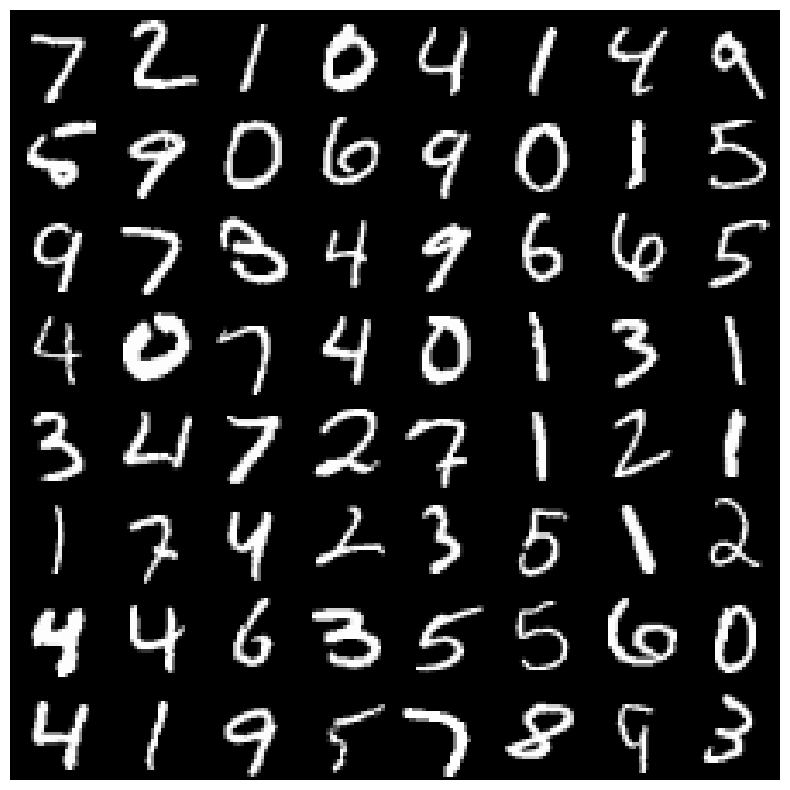

In [12]:
def get_fixed_samples(loader, n_viz):
    imgs, labels = [], []
    count = 0
    for batch_X, batch_y in loader:
        x, y = batch_X, batch_y
        imgs.append(x)
        labels.append(y)
        count += x.shape[0]
        if count >= n_viz: break
    return jnp.concatenate(imgs, axis=0)[:n_viz], jnp.concatenate(labels, axis=0)[:n_viz]

fixed_in_imgs, fixed_labels = get_fixed_samples(test_loader, NVIZ)

# Save real samples
grid_real = vu.set_grid(fixed_in_imgs, num_cells=NVIZ)
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(np.array(vu.normalize(grid_real, 0, 1)), (1, 2, 0)), cmap='gray')
plt.axis('off')
plt.savefig(os.path.join(checkpoint_dir, 'real_samples.jpg'), bbox_inches='tight')
plt.show()
plt.close()

### Langkah 9: Loop Pelatihan
Sekarang kita mulai proses pembelajaran. Kita akan melakukan iterasi melalui data latihan dan menjalankan fungsi `train_step`.

100%|██████████| 469/469 [00:03<00:00, 117.33batch/s, loss=0.23029953]


Epoch [1/50], loss: 0.2141, elapsed_t:  4.01 secs
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/dae_gaussian_mnist/epoch_1.safetensors


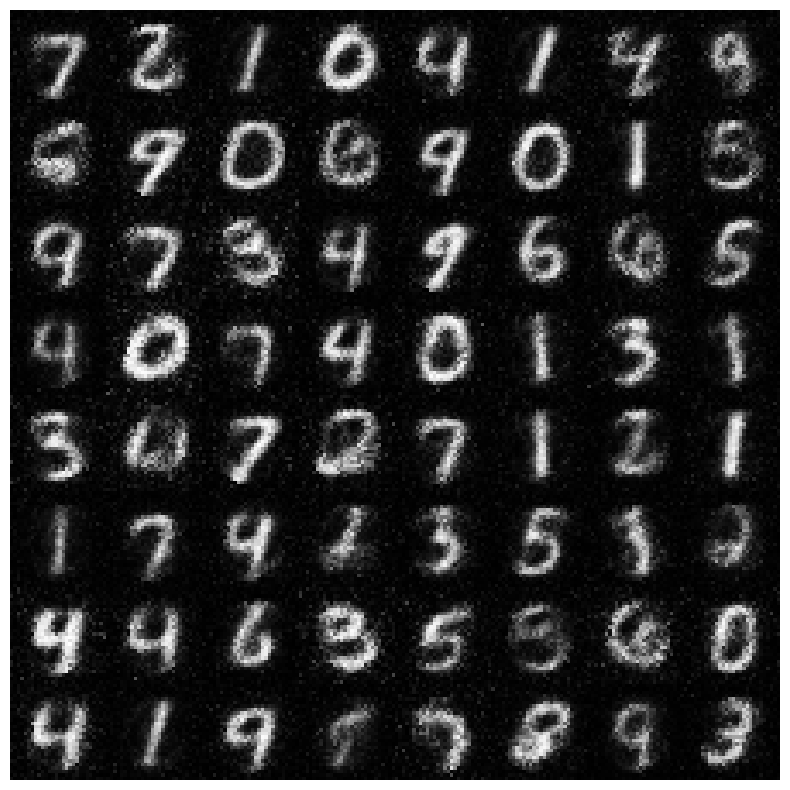

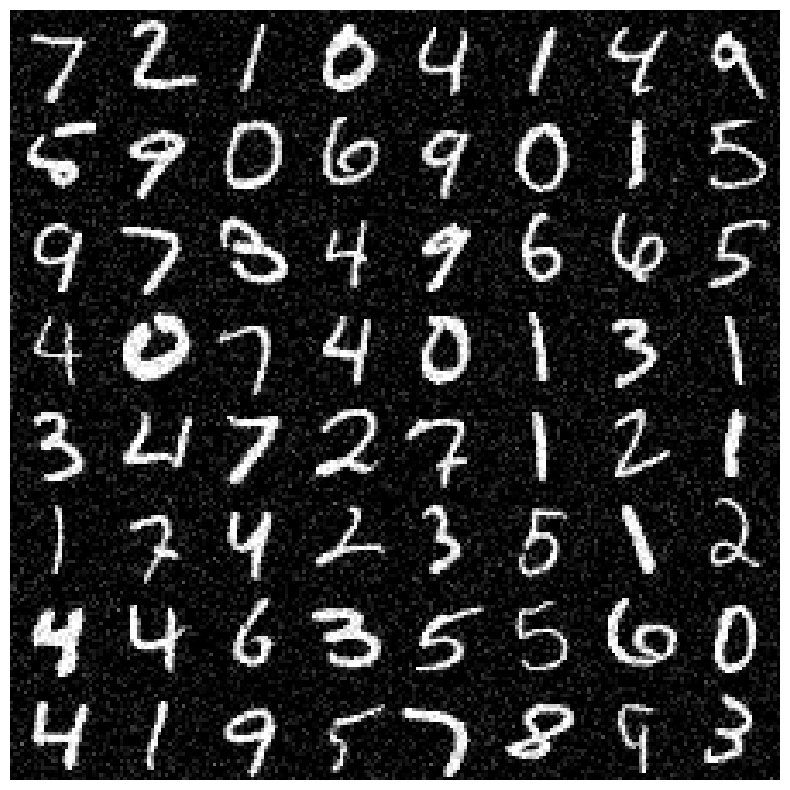

100%|██████████| 469/469 [00:03<00:00, 131.07batch/s, loss=0.08928601] 


Epoch [2/50], loss: 0.0864, elapsed_t:  3.58 secs


100%|██████████| 469/469 [00:03<00:00, 134.36batch/s, loss=0.05795125]


Epoch [3/50], loss: 0.0567, elapsed_t:  3.49 secs


100%|██████████| 469/469 [00:03<00:00, 133.67batch/s, loss=0.043198153]


Epoch [4/50], loss: 0.0425, elapsed_t:  3.51 secs


100%|██████████| 469/469 [00:03<00:00, 133.27batch/s, loss=0.034752976]


Epoch [5/50], loss: 0.0343, elapsed_t:  3.52 secs


100%|██████████| 469/469 [00:03<00:00, 127.82batch/s, loss=0.029318724]


Epoch [6/50], loss: 0.0290, elapsed_t:  3.67 secs


100%|██████████| 469/469 [00:03<00:00, 132.18batch/s, loss=0.025513725]


Epoch [7/50], loss: 0.0253, elapsed_t:  3.55 secs


100%|██████████| 469/469 [00:03<00:00, 131.87batch/s, loss=0.022711102]


Epoch [8/50], loss: 0.0226, elapsed_t:  3.56 secs


100%|██████████| 469/469 [00:03<00:00, 131.94batch/s, loss=0.020614618]


Epoch [9/50], loss: 0.0205, elapsed_t:  3.56 secs


100%|██████████| 469/469 [00:03<00:00, 132.92batch/s, loss=0.018967012]


Epoch [10/50], loss: 0.0189, elapsed_t:  3.53 secs


100%|██████████| 469/469 [00:03<00:00, 130.51batch/s, loss=0.017646153]

Epoch [11/50], loss: 0.0176, elapsed_t:  3.59 secs
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/dae_gaussian_mnist/epoch_11.safetensors


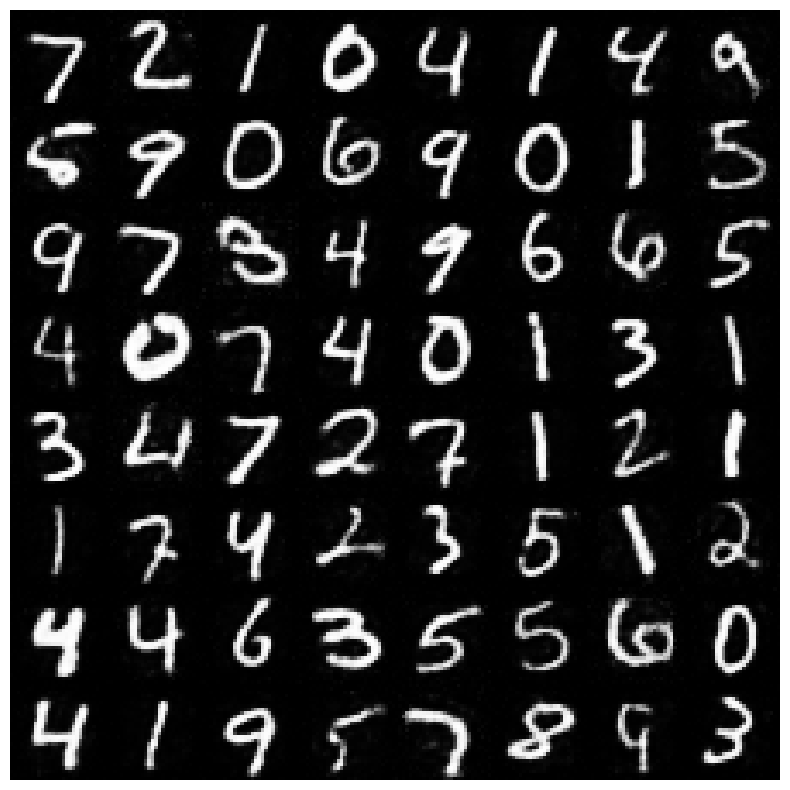

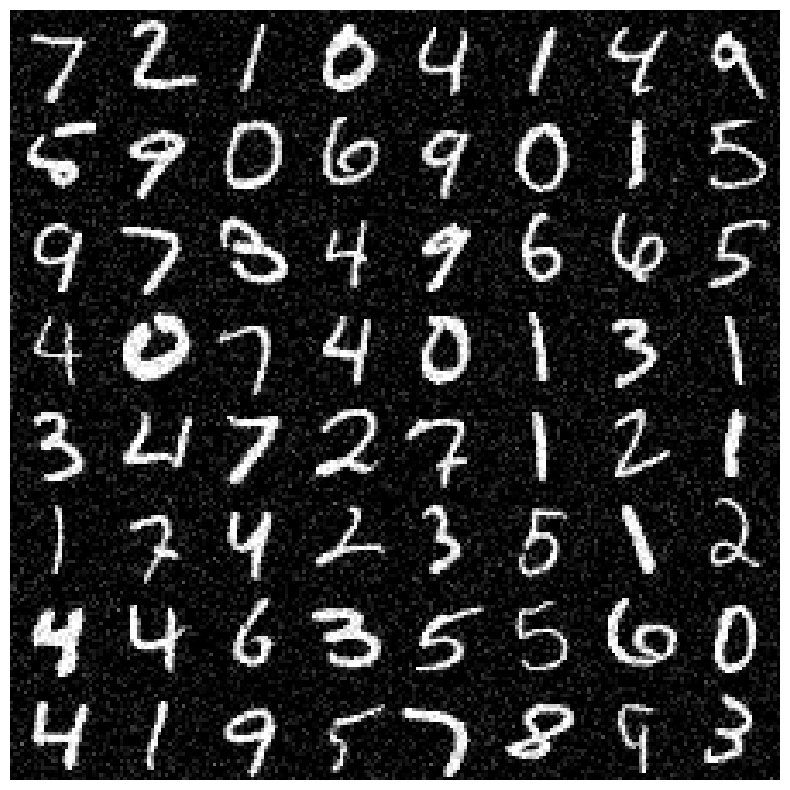

100%|██████████| 469/469 [00:03<00:00, 131.18batch/s, loss=0.016603779]


Epoch [12/50], loss: 0.0165, elapsed_t:  3.58 secs


100%|██████████| 469/469 [00:03<00:00, 131.71batch/s, loss=0.015730856]


Epoch [13/50], loss: 0.0157, elapsed_t:  3.56 secs


100%|██████████| 469/469 [00:03<00:00, 131.11batch/s, loss=0.015019468] 


Epoch [14/50], loss: 0.0150, elapsed_t:  3.58 secs


100%|██████████| 469/469 [00:03<00:00, 130.44batch/s, loss=0.014413504]


Epoch [15/50], loss: 0.0144, elapsed_t:  3.60 secs


100%|██████████| 469/469 [00:03<00:00, 130.61batch/s, loss=0.013901695]


Epoch [16/50], loss: 0.0139, elapsed_t:  3.59 secs


100%|██████████| 469/469 [00:03<00:00, 129.85batch/s, loss=0.013457136]


Epoch [17/50], loss: 0.0134, elapsed_t:  3.61 secs


100%|██████████| 469/469 [00:03<00:00, 127.60batch/s, loss=0.01309189] 


Epoch [18/50], loss: 0.0131, elapsed_t:  3.68 secs


100%|██████████| 469/469 [00:03<00:00, 129.87batch/s, loss=0.012759632]


Epoch [19/50], loss: 0.0127, elapsed_t:  3.61 secs


100%|██████████| 469/469 [00:03<00:00, 132.30batch/s, loss=0.012439765]


Epoch [20/50], loss: 0.0124, elapsed_t:  3.55 secs


100%|██████████| 469/469 [00:03<00:00, 128.88batch/s, loss=0.012198277]


Epoch [21/50], loss: 0.0122, elapsed_t:  3.64 secs
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/dae_gaussian_mnist/epoch_21.safetensors


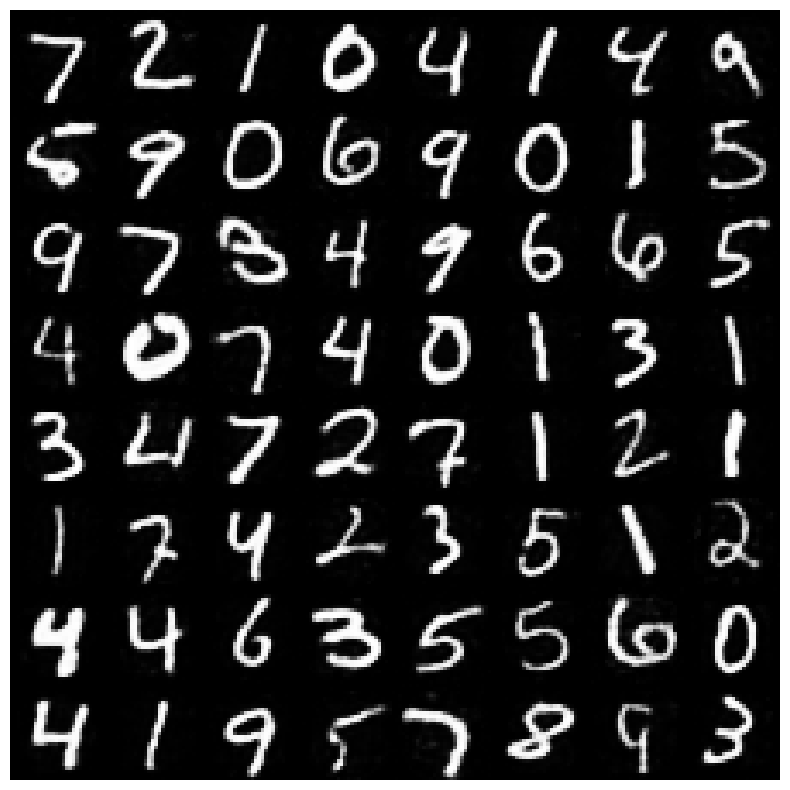

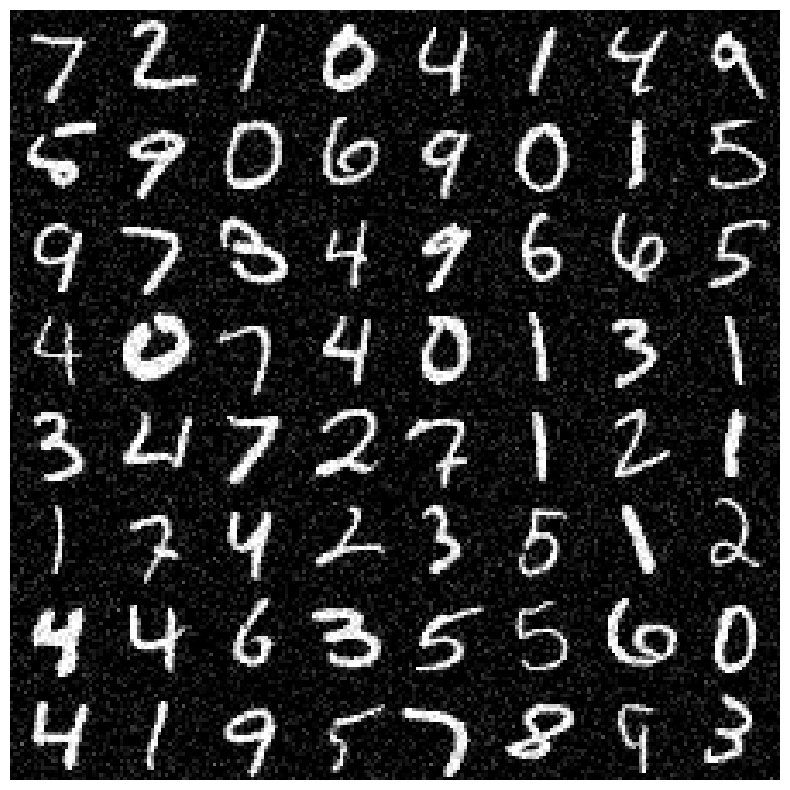

100%|██████████| 469/469 [00:03<00:00, 128.38batch/s, loss=0.011967929]


Epoch [22/50], loss: 0.0119, elapsed_t:  3.65 secs


100%|██████████| 469/469 [00:03<00:00, 127.08batch/s, loss=0.011737204]


Epoch [23/50], loss: 0.0117, elapsed_t:  3.69 secs


100%|██████████| 469/469 [00:03<00:00, 127.30batch/s, loss=0.011560625]


Epoch [24/50], loss: 0.0115, elapsed_t:  3.69 secs


100%|██████████| 469/469 [00:03<00:00, 129.98batch/s, loss=0.011383296]


Epoch [25/50], loss: 0.0114, elapsed_t:  3.61 secs


100%|██████████| 469/469 [00:03<00:00, 128.64batch/s, loss=0.011213711]


Epoch [26/50], loss: 0.0112, elapsed_t:  3.65 secs


100%|██████████| 469/469 [00:03<00:00, 129.77batch/s, loss=0.011085622]


Epoch [27/50], loss: 0.0111, elapsed_t:  3.62 secs


100%|██████████| 469/469 [00:03<00:00, 130.82batch/s, loss=0.010938253]


Epoch [28/50], loss: 0.0109, elapsed_t:  3.59 secs


100%|██████████| 469/469 [00:03<00:00, 129.51batch/s, loss=0.010829527]


Epoch [29/50], loss: 0.0108, elapsed_t:  3.62 secs


100%|██████████| 469/469 [00:03<00:00, 124.67batch/s, loss=0.010704315]


Epoch [30/50], loss: 0.0107, elapsed_t:  3.76 secs


100%|██████████| 469/469 [00:03<00:00, 128.19batch/s, loss=0.0106053725]

Epoch [31/50], loss: 0.0106, elapsed_t:  3.66 secs
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/dae_gaussian_mnist/epoch_31.safetensors


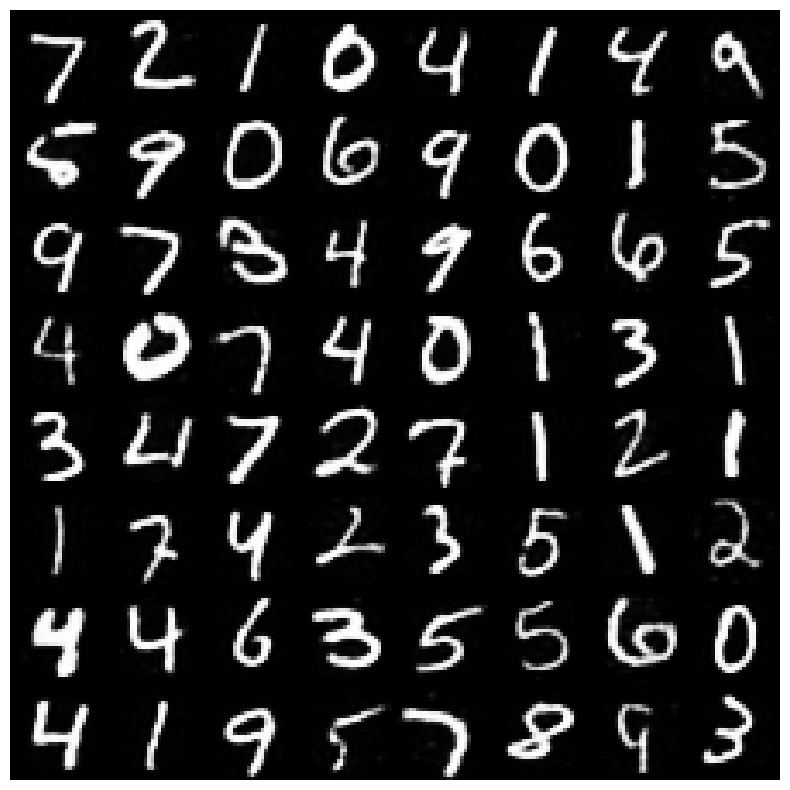

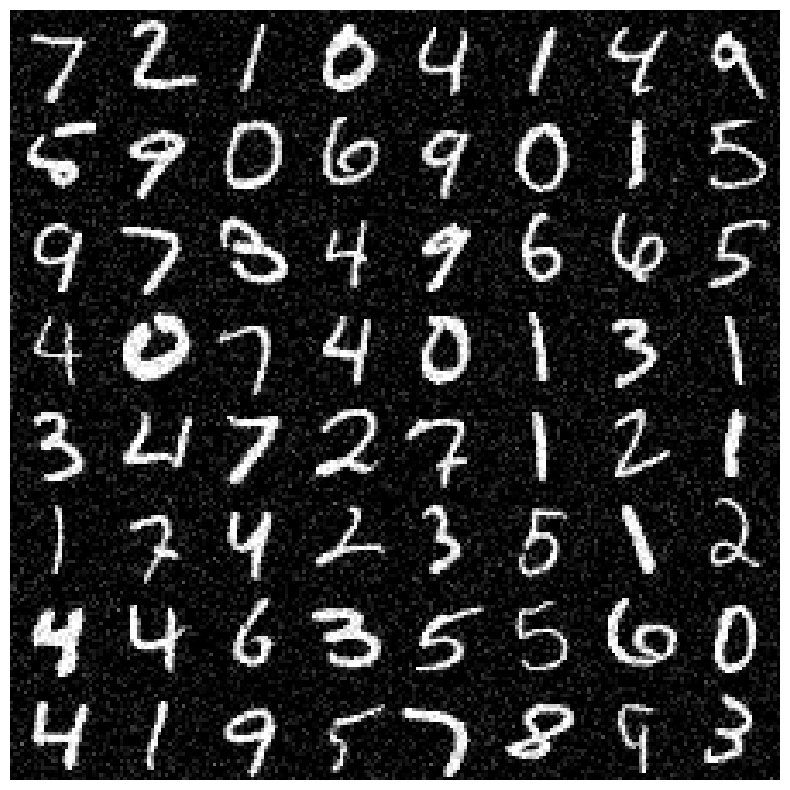

100%|██████████| 469/469 [00:03<00:00, 124.87batch/s, loss=0.010491624]


Epoch [32/50], loss: 0.0105, elapsed_t:  3.76 secs


100%|██████████| 469/469 [00:03<00:00, 129.83batch/s, loss=0.010424091]


Epoch [33/50], loss: 0.0104, elapsed_t:  3.61 secs


100%|██████████| 469/469 [00:03<00:00, 132.59batch/s, loss=0.010333994] 


Epoch [34/50], loss: 0.0103, elapsed_t:  3.54 secs


100%|██████████| 469/469 [00:03<00:00, 133.40batch/s, loss=0.010254481]


Epoch [35/50], loss: 0.0103, elapsed_t:  3.52 secs


100%|██████████| 469/469 [00:03<00:00, 127.02batch/s, loss=0.01018358] 


Epoch [36/50], loss: 0.0102, elapsed_t:  3.69 secs


100%|██████████| 469/469 [00:03<00:00, 129.68batch/s, loss=0.010103667]


Epoch [37/50], loss: 0.0101, elapsed_t:  3.62 secs


100%|██████████| 469/469 [00:03<00:00, 133.03batch/s, loss=0.010052506]


Epoch [38/50], loss: 0.0101, elapsed_t:  3.53 secs


100%|██████████| 469/469 [00:03<00:00, 133.41batch/s, loss=0.009980334]


Epoch [39/50], loss: 0.0100, elapsed_t:  3.52 secs


100%|██████████| 469/469 [00:03<00:00, 123.98batch/s, loss=0.009922196]


Epoch [40/50], loss: 0.0099, elapsed_t:  3.78 secs


100%|██████████| 469/469 [00:03<00:00, 130.05batch/s, loss=0.0098629575]

Epoch [41/50], loss: 0.0099, elapsed_t:  3.61 secs
Model disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/dae_gaussian_mnist/epoch_41.safetensors


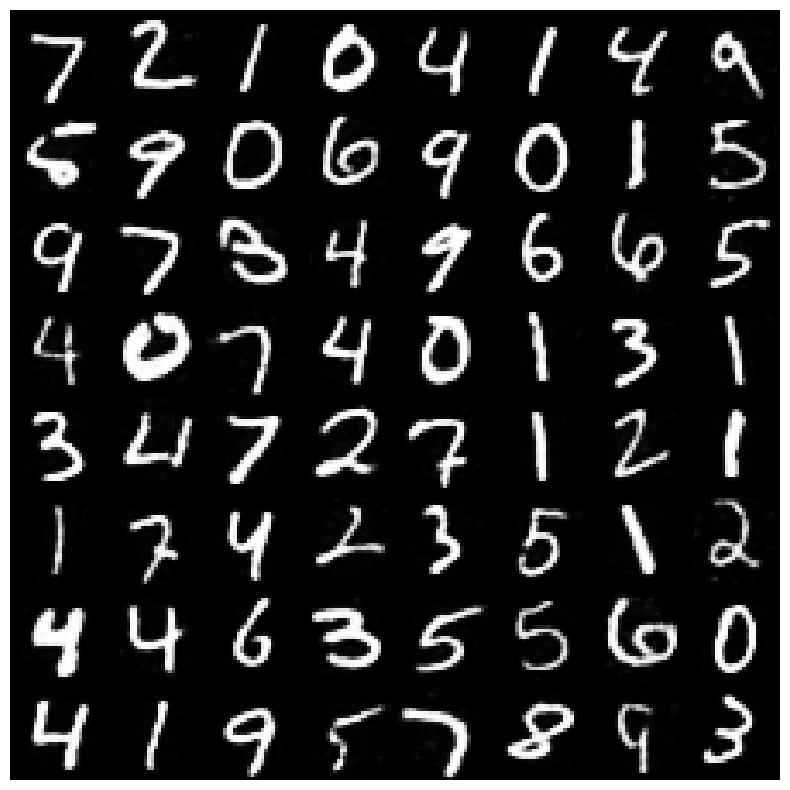

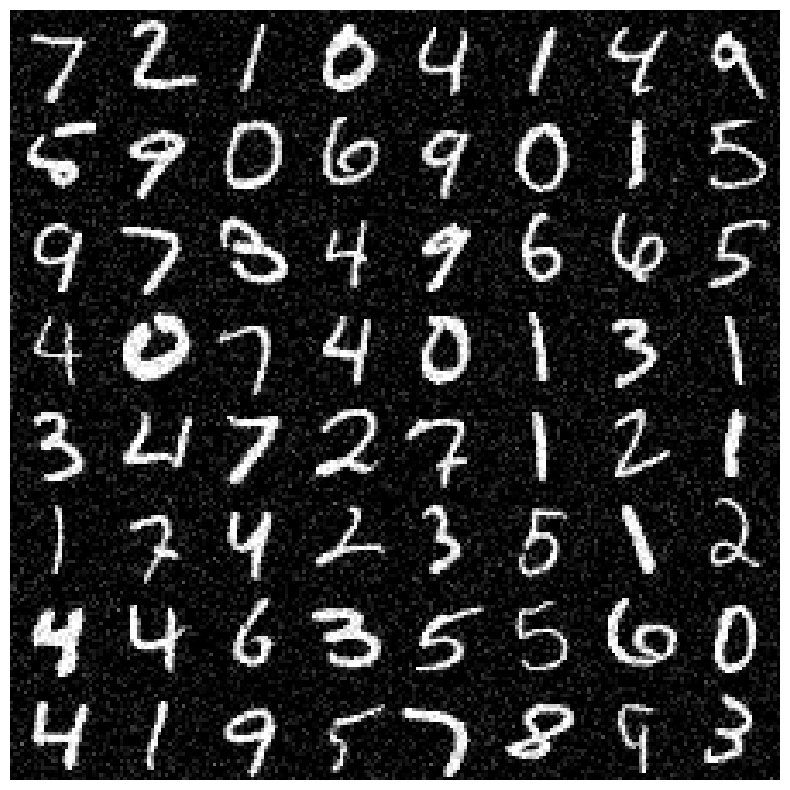

100%|██████████| 469/469 [00:03<00:00, 130.94batch/s, loss=0.009803236]


Epoch [42/50], loss: 0.0098, elapsed_t:  3.58 secs


100%|██████████| 469/469 [00:03<00:00, 132.91batch/s, loss=0.009758631] 


Epoch [43/50], loss: 0.0098, elapsed_t:  3.53 secs


100%|██████████| 469/469 [00:03<00:00, 133.87batch/s, loss=0.0097118905]


Epoch [44/50], loss: 0.0097, elapsed_t:  3.50 secs


100%|██████████| 469/469 [00:03<00:00, 130.88batch/s, loss=0.009654511]


Epoch [45/50], loss: 0.0097, elapsed_t:  3.58 secs


100%|██████████| 469/469 [00:03<00:00, 130.30batch/s, loss=0.009620073] 


Epoch [46/50], loss: 0.0096, elapsed_t:  3.60 secs


100%|██████████| 469/469 [00:03<00:00, 132.53batch/s, loss=0.009585776]


Epoch [47/50], loss: 0.0096, elapsed_t:  3.54 secs


100%|██████████| 469/469 [00:03<00:00, 129.45batch/s, loss=0.009573863]


Epoch [48/50], loss: 0.0096, elapsed_t:  3.62 secs


100%|██████████| 469/469 [00:03<00:00, 131.00batch/s, loss=0.009559134]


Epoch [49/50], loss: 0.0095, elapsed_t:  3.58 secs


100%|██████████| 469/469 [00:03<00:00, 131.97batch/s, loss=0.009482224] 

Epoch [50/50], loss: 0.0095, elapsed_t:  3.55 secs


In [13]:
# Train model
for epoch in range(NUM_EPOCH):
    start_t = timer.time()
    metrics.reset()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (X, y) in enumerate(tepoch):
            # X is (B, 1, 28, 28)
            X_flat = X.reshape(X.shape[0], -1)
            
            if IS_DENOISING:
                # Use batch_idx as seed for noise reproducibility if needed
                noise_seed = epoch * 10000 + batch_idx
                Xn = add_noise(X, noise_type=NOISE_TYPE, seed=noise_seed)
                Xn_flat = Xn.reshape(Xn.shape[0], -1)
            else:
                Xn_flat = X_flat
            
            train_step(model, optimizer, metrics, jnp.array(X_flat), jnp.array(Xn_flat))
            
            if batch_idx % 100 == 0:
                tepoch.set_postfix(loss=metrics.compute()['loss'])

    elapsed_t = timer.time() - start_t
    epoch_loss = metrics.compute()['loss']
    print(f'Epoch [{epoch+1}/{NUM_EPOCH}], loss: {epoch_loss:.4f}, elapsed_t: {elapsed_t: 0.2f} secs')

    if epoch %  10 != 0:
        continue
    
    # Save model
    mu.save_checkpoint(model, epoch + 1, filedir=checkpoint_dir)
    
    # Visualization
    fixed_in_flatten = fixed_in_imgs.reshape(fixed_in_imgs.shape[0], -1)
    rec_imgs_flat = model(fixed_in_flatten)
    rec_imgs = rec_imgs_flat.reshape(-1, 1, 28, 28)
    
    grid_rec = vu.set_grid(rec_imgs, num_cells=NVIZ)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np.array(vu.normalize(grid_rec, 0, 1)), (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.savefig(os.path.join(checkpoint_dir, f'reconstructed_samples_{epoch}.jpg'), bbox_inches='tight')
    plt.show()
    plt.close()

    if IS_DENOISING:
        # Static noise for visualization
        fixed_in_n = add_noise(fixed_in_imgs, noise_type=NOISE_TYPE, seed=42)
        
        grid_noisy = vu.set_grid(fixed_in_n, num_cells=NVIZ)
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(np.array(vu.normalize(grid_noisy, 0, 1)), (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(checkpoint_dir, 'noisy_samples.jpg'), bbox_inches='tight')
        plt.show()
        plt.close()

    

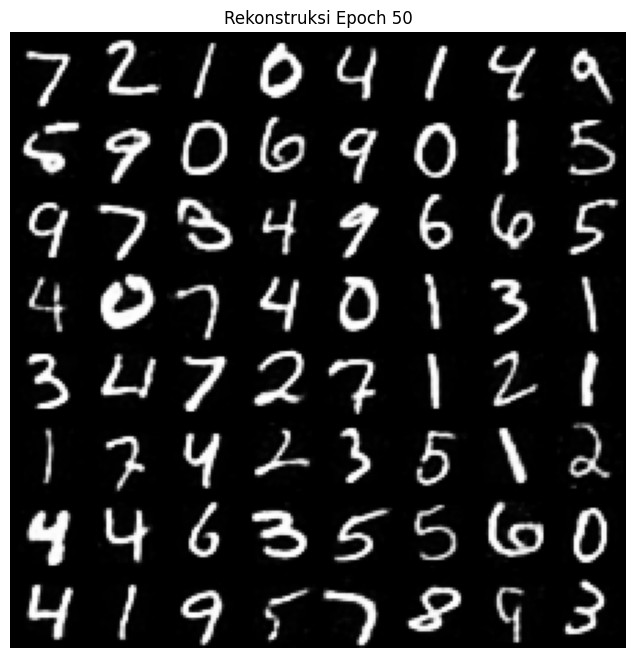

In [16]:
# Visualizing reconstruction
fixed_in_flatten = fixed_in_imgs.reshape(fixed_in_imgs.shape[0], -1)
rec_imgs_flat = model(fixed_in_flatten)
rec_imgs = rec_imgs_flat.reshape(-1, 1, 28, 28)

grid_rec = vu.set_grid(rec_imgs, num_cells=NVIZ)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(np.array(vu.normalize(grid_rec, 0, 1)), (1, 2, 0)), cmap='gray')
plt.axis('off')
plt.title(f"Rekonstruksi Epoch {epoch+1}")
plt.show()

### Langkah 10: Analisis Ruang Laten dengan t-SNE
Terakhir, kita memvisualisasikan bagaimana Autoencoder mengelompokkan digit yang berbeda dalam ruang laten (hasil kompresi encoder) menggunakan algoritma t-SNE.

Menghasilkan plot t-SNE...
generating t-SNE plot...


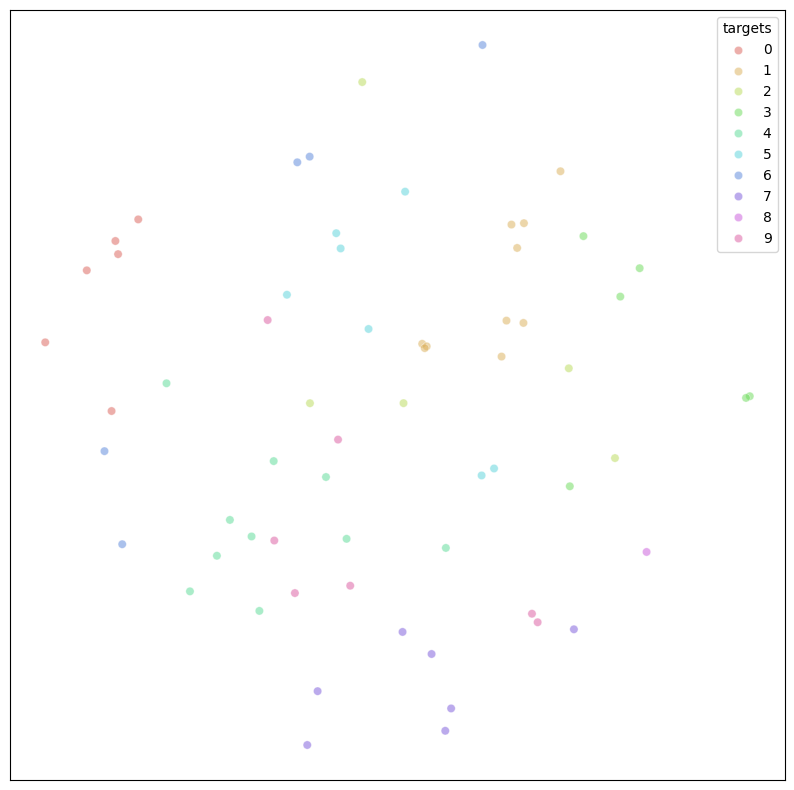

Plat t-SNE disimpan ke /Users/mghifary/Work/Code/AI/IF5281/jax/models/dae_gaussian_mnist/tsne_49.jpg


<Figure size 1000x1000 with 0 Axes>

In [18]:
print("Menghasilkan plot t-SNE...")
# t-SNE
Z = model.encoder(fixed_in_flatten)
tsne_path = os.path.join(checkpoint_dir, f"tsne_{epoch}.jpg")
vu.plot_features_tsne(np.array(Z), np.array(fixed_labels), tsne_path, show=True)
print(f"Plat t-SNE disimpan ke {tsne_path}")